In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [6]:
# Reflect an existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save classes to tables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session
session = Session(engine)

In [10]:
# Inspect measurement schema
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Inspect station schema
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
# Call Measurement and sort descending to find the most recent (last record) data point in the database
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


In [13]:
# Calculate the date 1 year ago from the last data point in the database
# Extract string from query object
recent_date = list(np.ravel(recent_date))[0]
recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d')


# Extract year, month, and day as integers
Year = int(dt.datetime.strftime(recent_date, '%Y'))
Month = int(dt.datetime.strftime(recent_date, '%m'))
Day = int(dt.datetime.strftime(recent_date, '%d'))

# Formating Recent date
recent_date = dt.date(Year, Month, Day)
print(recent_date)

# Calculate one year before latest date
one_year = dt.date(Year, Month, Day) - dt.timedelta(days=365)
print(one_year)

2017-08-23
2016-08-23


In [14]:
#query for dates and precipitation for the latest year
rain_year = (session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year).order_by(Measurement.date).all())
rain_year_df = pd.DataFrame(rain_year)
rain_year_df = rain_year_df.dropna()
rain_year_df = rain_year_df.set_index('date')

rain_year_df

prcp
date            
2016-08-23  0.00
2016-08-23  0.15
2016-08-23  0.05
2016-08-23  0.02
2016-08-23  1.79
...          ...
2017-08-22  0.50
2017-08-23  0.00
2017-08-23  0.00
2017-08-23  0.08
2017-08-23  0.45

[2021 rows x 1 columns]

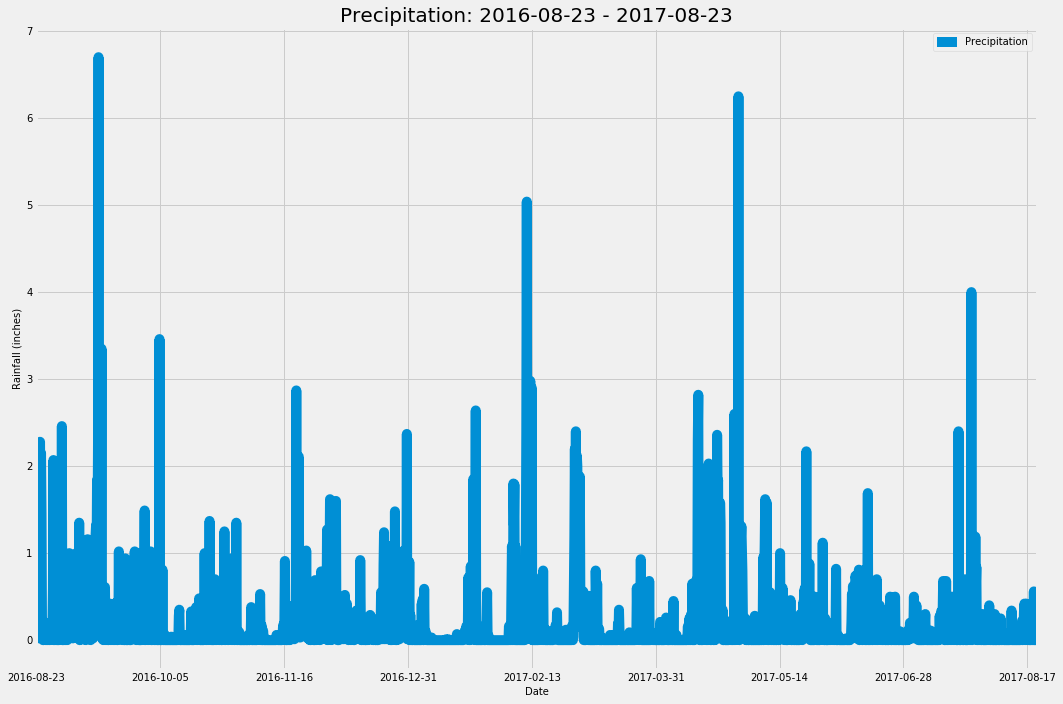

In [15]:
##### Plot with pandas
rain_year_df.plot(linewidth=10, figsize=(15,10), fontsize=10)
plt.xlabel("Date", fontsize=10)
plt.title(f"Precipitation: {one_year} - {recent_date}", fontsize=20)
plt.ylabel("Rainfall (inches)", fontsize=10)
plt.legend(["Precipitation"], loc="best", fontsize=10)
plt.tight_layout()
plt.savefig('Images/Precipitation_one_year.png', DPI=200)

In [16]:
# Summary statistics for the precipitation data
rain_year_df.describe()

prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000

In [17]:
# Count distinct stations
station_count = session.query(Measurement.station).group_by(Measurement.station).count()
station_count

9

In [18]:
# Activisty of stations, counted by instances in database, descending order
activity_count = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
activity_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id for the highest reorded calculated the lowest,highest , and average temperature
most_active_station = 'USC00519281'
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

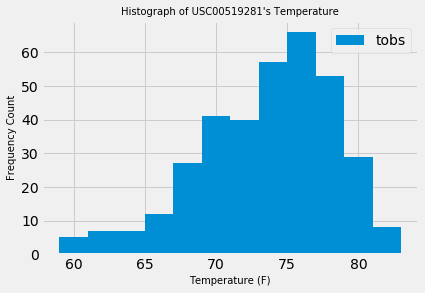

In [20]:
#query for the last year of temperature data
temp_active = (session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= one_year).
            filter(Measurement.station == most_active_station).order_by(Measurement.date).all())

#convert query object to data frame
temp_histo = pd.DataFrame(temp_active)
temp_histo = temp_histo.set_index('date')

#sory by date
temp_histo = temp_histo.sort_index(ascending=True)

#histogram plot with pandas
temp_histo.plot(kind='hist', bins=12)

plt.xlabel('Temperature (F)', fontsize=10)
plt.ylabel('Frequency Count', fontsize=10)
plt.title(f"Histograph of {most_active_station}'s Temperature", fontsize=10)
plt.savefig('Images/Station_histo.png', DPI=200)

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Set trip dates and previous dates that match
trip = '2020-12-17 to 2020-12-30'
trip_start = '2016-12-17'
trip_end = '2016-12-30'

In [23]:
# Using the previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for my trip using the previous year's data for those same dates.
calc_temp = calc_temps(trip_start, trip_end)
temps_df = pd.DataFrame(calc_temp, columns=["tmin","tave","tmax"])
print(f"tmin, tave, tmax for {trip_start} to {trip_end}:")
temps_df

tmin, tave, tmax for 2016-12-17 to 2016-12-30:


tmin       tave  tmax
0  65.0  72.355556  78.0

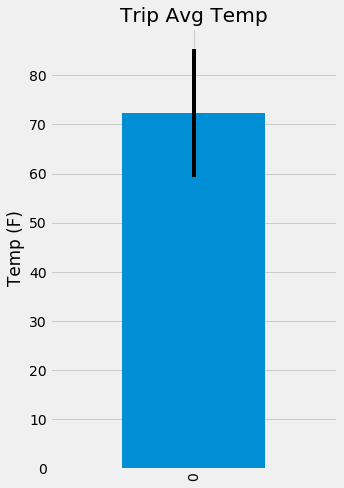

In [24]:
# Bar chart for trip avg temp. Used the average temperature for the y value. Used peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temps_df.plot.bar(y='tave', yerr=(temps_df['tmax'] - temps_df['tmin']), title='Trip Avg Temp', figsize=(5,7))
plt.xticks = np.arange(len(temps_df))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig('Images/Trip_Avg_Temp.png', DPI=200)
plt.show()

In [25]:
# Calculated total amount of rainfall per weather station for trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_station = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                    filter(Measurement.station == Station.station).filter(Measurement.date >= trip_start).\
                    filter(Measurement.date <=trip_end).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
print(rainfall_station)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 9.39), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.86), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.87), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.22), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.9800000000000002), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.38), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.06)]


In [26]:
# Load into a dataframe for easy review
trip_rainfall = pd.DataFrame(rainfall_station, columns = ['Station', 'Name', 'Latitude', 'Longitude', 'Elevation', 'Precipitation (in.)'])
trip_rainfall

Station                                    Name  Latitude  Longitude  \
0  USC00516128            MANOA LYON ARBO 785.2, HI US  21.33310 -157.80250   
1  USC00519281                     WAIHEE 837.5, HI US  21.45167 -157.84889   
2  USC00513117                    KANEOHE 838.1, HI US  21.42340 -157.80150   
3  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130 -157.83740   
4  USC00519523      WAIMANALO EXPERIMENTAL FARM, HI US  21.33556 -157.71139   
5  USC00519397                    WAIKIKI 717.2, HI US  21.27160 -157.81680   
6  USC00517948                       PEARL CITY, HI US  21.39340 -157.97510   

   Elevation  Precipitation (in.)  
0      152.4                 9.39  
1       32.9                 2.86  
2       14.6                 1.87  
3        7.0                 1.22  
4       19.5                 0.98  
5        3.0                 0.38  
6       11.9                 0.06

## Optional Challenge Assignment

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# Convert trip start and end dates to integers
startNum = int(dt.datetime.strptime(trip_start, '%Y-%m-%d').strftime('%d'))
endNum = int(dt.datetime.strptime(trip_end, '%Y-%m-%d').strftime('%d'))
# Calculate trip length
tripLength = endNum - startNum + 1

#start date as datetime object
startDate = dt.datetime.strptime(trip_start, '%Y-%m-%d')
#list dates (MM-DD) of trip
dateList = [dt.datetime.strftime(startDate + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, tripLength)]

#calculate normals for each date
tripNormals = [daily_normals(date) for date in dateList]

tripNormals

[[(63.0, 70.64, 77.0)],
 [(63.0, 71.28, 77.0)],
 [(67.0, 72.0, 78.0)],
 [(65.0, 72.91304347826087, 81.0)],
 [(67.0, 72.13953488372093, 78.0)],
 [(67.0, 71.1304347826087, 77.0)],
 [(61.0, 70.34693877551021, 78.0)],
 [(62.0, 70.0625, 78.0)],
 [(60.0, 71.75, 79.0)],
 [(63.0, 71.44680851063829, 77.0)],
 [(62.0, 71.91666666666667, 79.0)],
 [(62.0, 70.52083333333333, 77.0)],
 [(57.0, 70.29166666666667, 78.0)],
 [(63.0, 69.86363636363636, 76.0)]]

In [29]:
#extract normals into a list of lists
tripNormals = [np.array(normal[0]) for normal in tripNormals]

#convert normals list into a data frame
normalsTable = pd.DataFrame(tripNormals)
#add date column
normalsTable["Date"] = dateList
#set index and rename columns
normalsTable = normalsTable.set_index("Date")
normalsTable = normalsTable.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})

normalsTable

Low Temp   Avg Temp  High Temp
Date                                 
12-17      63.0  70.640000       77.0
12-18      63.0  71.280000       77.0
12-19      67.0  72.000000       78.0
12-20      65.0  72.913043       81.0
12-21      67.0  72.139535       78.0
12-22      67.0  71.130435       77.0
12-23      61.0  70.346939       78.0
12-24      62.0  70.062500       78.0
12-25      60.0  71.750000       79.0
12-26      63.0  71.446809       77.0
12-27      62.0  71.916667       79.0
12-28      62.0  70.520833       77.0
12-29      57.0  70.291667       78.0
12-30      63.0  69.863636       76.0

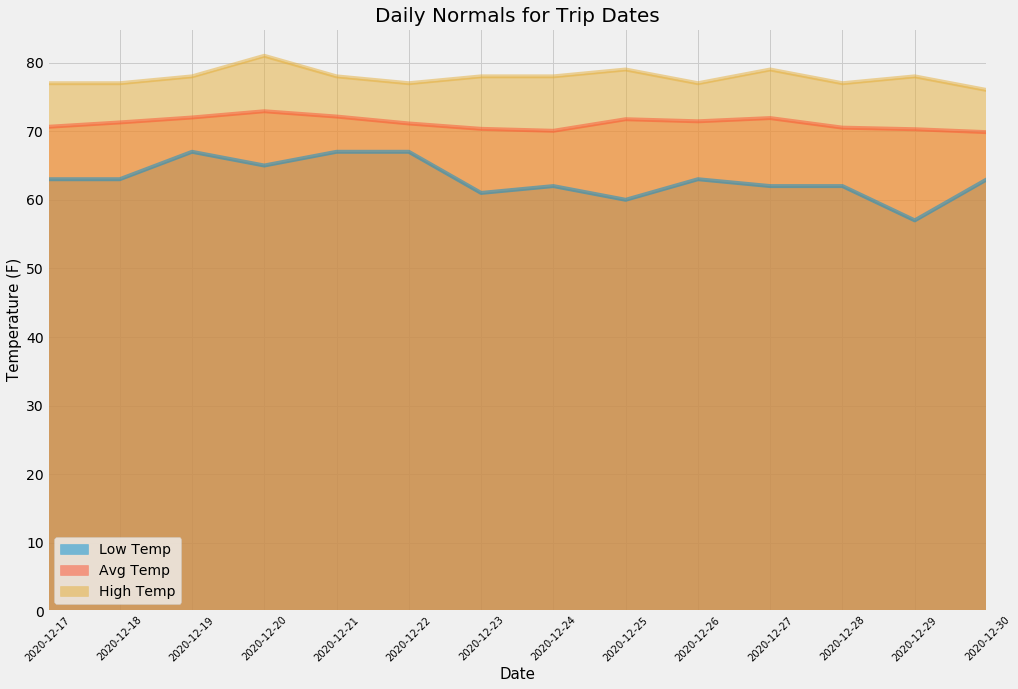

In [30]:
#area plot of the normal temps for the planned trip dates
ax= normalsTable.plot.area(stacked=False, figsize = (15, 10)) 
#set labels
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Temperature (F)', fontsize=15)
ax.set_title('Daily Normals for Trip Dates', fontsize=20)

dates = [f"2020-{dateList}" for dateList in dateList]
ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(dates, rotation = 45, fontsize=10)
plt.savefig('Images/Normals_for_trip_dates.png', DPI=200)